<div align="center">
<h1><img width="30" src="https://madewithml.com/static/images/rounded_logo.png">&nbsp;<a href="https://madewithml.com/">Made With ML</a></h1>
    <h3>ML for Developers</h3>
    Design · Develop · Deploy · Iterate
</div>

<br>

<div align="center">
    <a target="_blank" href="https://madewithml.com"><img src="https://img.shields.io/badge/Subscribe-40K-brightgreen"></a>&nbsp;
    <a target="_blank" href="https://github.com/GokuMohandas/MadeWithML"><img src="https://img.shields.io/github/stars/GokuMohandas/MadeWithML.svg?style=social&label=Star"></a>&nbsp;
    <a target="_blank" href="https://www.linkedin.com/in/goku"><img src="https://img.shields.io/badge/style--5eba00.svg?label=LinkedIn&logo=linkedin&style=social"></a>&nbsp;
    <a target="_blank" href="https://twitter.com/GokuMohandas"><img src="https://img.shields.io/twitter/follow/GokuMohandas.svg?label=Follow&style=social"></a>
    <br>
    🔥&nbsp; Among the <a href="https://github.com/GokuMohandas/MadeWithML" target="_blank">top ML</a> repositories on GitHub
</div>

<br>
<hr>

# Generative AI

In our [Made With ML course](https://madewithml.com/) we will be fine-tuning an LLM for a supervised classification task. The specific class of LLMs we'll be using is called [BERT](https://en.wikipedia.org/wiki/BERT_(language_model)). Bert models are encoder-only models and are the gold-standard for supervised NLP tasks. However, you may be wondering how do all the (much larger) LLM, created for generative applications, fare ([GPT 4](https://openai.com/research/gpt-4), [Falcon 40B](https://huggingface.co/tiiuae/falcon-40b), [Llama 2](https://ai.meta.com/llama/), etc.)?

> We chose the smaller BERT model for our course because it's easier to train and fine-tune. However, the workflow for fine-tuning the larger LLMs are quite similar as well. They do require much more compute but Ray abstracts away the scaling complexities involved with that.

## Set up

In [ ]:
!pip install openai==0.27.8 tqdm==4.65.0 -q

You'll need to first sign up for an [OpenAI account](https://platform.openai.com/signup) and then grab your API key from [here](https://platform.openai.com/account/api-keys).

In [ ]:
import openai
# openai.api_key = ""

### Load data

In [ ]:
import pandas as pd

In [ ]:
# Load training data
DATASET_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/dataset.csv"
train_df = pd.read_csv(DATASET_LOC)
train_df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


In [ ]:
# Unique labels
tags = train_df.tag.unique().tolist()
tags

['computer-vision', 'other', 'natural-language-processing', 'mlops']

In [ ]:
# Load inference dataset
HOLDOUT_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/holdout.csv"
test_df = pd.read_csv(HOLDOUT_LOC)

### Utilities

We'll define a few utility functions to make the OpenAI request and to store our predictions. While we could perform batch prediction by loading samples until the context length is reached, we'll just perform one at a time since it's not too many data points and we can have fully deterministic behavior (if you insert new data, etc.). We'll also added some reliability in case we overload the endpoints with too many request at once.

In [ ]:
import json
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from sklearn.metrics import precision_recall_fscore_support
import time
from tqdm import tqdm

In [ ]:
# Query OpenAI endpoint
system_content = "you only answer in rhymes"  # system content (behavior)
assistant_content = ""  # assistant content (context)
user_content = "how are you"  # user content (message)
response = openai.ChatCompletion.create(
    # model="gpt-3.5-turbo-0613",
    model='gpt-3.5-turbo',
    messages=[
        {"role": "system", "content": system_content},
        {"role": "assistant", "content": assistant_content},
        {"role": "user", "content": user_content},
    ],
)
print (response.to_dict()["choices"][0].to_dict()["message"]["content"])

I'm doing quite well, thank you for asking,
Ready to help with any tasking.


Now let's create a function that can predict tags for a given sample.

In [ ]:
def get_tag(model, system_content="", assistant_content="", user_content=""):
    try:
        # Get response from OpenAI
        response = openai.ChatCompletion.create(
            model=model,
            messages=[
                {"role": "system", "content": system_content},
                {"role": "assistant", "content": assistant_content},
                {"role": "user", "content": user_content},
            ],
        )
        predicted_tag = response.to_dict()["choices"][0].to_dict()["message"]["content"]
        return predicted_tag

    except (openai.error.ServiceUnavailableError, openai.error.APIError) as e:
        return None

In [ ]:
# Get tag
model = "gpt-3.5-turbo-0613"
system_context = f"""
    You are a NLP prediction service that predicts the label given an input's title and description.
    You must choose between one of the following labels for each input: {tags}.
    Only respond with the label name and nothing else.
    """
assistant_content = ""
user_context = "Transfer learning with transformers: Using transformers for transfer learning on text classification tasks."
tag = get_tag(model=model, system_content=system_context, assistant_content=assistant_content, user_content=user_context)
print (tag)

natural-language-processing


Next, let's create a function that can predict tags for a list of inputs.

In [ ]:
# List of dicts w/ {title, description} (just the first 3 samples for now)
samples = test_df[["title", "description"]].to_dict(orient="records")[:3]
samples

[{'title': 'Diffusion to Vector',
  'description': 'Reference implementation of Diffusion2Vec (Complenet 2018) built on Gensim and NetworkX. '},
 {'title': 'Graph Wavelet Neural Network',
  'description': 'A PyTorch implementation of "Graph Wavelet Neural Network" (ICLR 2019) '},
 {'title': 'Capsule Graph Neural Network',
  'description': 'A PyTorch implementation of "Capsule Graph Neural Network" (ICLR 2019).'}]

In [ ]:
def get_predictions(inputs, model, system_content, assistant_content=""):
    y_pred = []
    for item in tqdm(inputs):
        # Convert item dict to string
        user_content = str(item)

        # Get prediction
        predicted_tag = get_tag(
            model=model, system_content=system_content,
            assistant_content=assistant_content, user_content=user_content)

        # # If error, try again after pause (repeatedly until success)
        # while predicted_tag is None:
        #     time.sleep(30)  # could also do exponential backoff
        #     predicted_tag = get_tag(
        #         model=model, system_content=system_content,
        #         assistant_content=assistant_content, user_content=user_content)

        # Add to list of predictions
        y_pred.append(predicted_tag)

    return y_pred

In [ ]:
# Get predictions for a list of inputs
get_predictions(inputs=samples, model=model, system_content=system_context)

100%|██████████| 3/3 [00:01<00:00,  1.72it/s]


['computer-vision', 'computer-vision', 'computer-vision']

Next we'll define a function that can clean our predictions in the event that it's not the proper format or has hallucinated a tag outside of our expected tags.

In [ ]:
def clean_predictions(y_pred, tags, default="other"):
    for i, item in enumerate(y_pred):
        if item not in tags:  # hallucinations
            y_pred[i] = default
        if item.startswith("'") and item.endswith("'"):  # GPT 4 likes to places quotes
            y_pred[i] = item[1:-1]
    return y_pred

> Open AI has now released [function calling](https://openai.com/blog/function-calling-and-other-api-updates) and [custom instructions](https://openai.com/blog/custom-instructions-for-chatgpt) which is worth exploring to avoid this manual cleaning.

Next, we'll define a function that will plot our ground truth labels and predictions.

In [ ]:
def plot_tag_dist(y_true, y_pred):
    # Distribution of tags
    true_tag_freq = dict(Counter(y_true))
    pred_tag_freq = dict(Counter(y_pred))
    df_true = pd.DataFrame({"tag": list(true_tag_freq.keys()), "freq": list(true_tag_freq.values()), "source": "true"})
    df_pred = pd.DataFrame({"tag": list(pred_tag_freq.keys()), "freq": list(pred_tag_freq.values()), "source": "pred"})
    df = pd.concat([df_true, df_pred], ignore_index=True)

    # Plot
    plt.figure(figsize=(10, 3))
    plt.title("Tag distribution", fontsize=14)
    ax = sns.barplot(x="tag", y="freq", hue="source", data=df)
    ax.set_xticklabels(list(true_tag_freq.keys()), rotation=0, fontsize=8)
    plt.legend()
    plt.show()

And finally, we'll define a function that will combine all the utilities above to predict, clean and plot our results.

In [ ]:
def evaluate(test_df, model, system_content, assistant_content, tags):
    # Predictions
    y_test = test_df.tag.to_list()
    test_samples = test_df[["title", "description"]].to_dict(orient="records")
    y_pred = get_predictions(
        inputs=test_samples, model=model,
        system_content=system_content, assistant_content=assistant_content)
    y_pred = clean_predictions(y_pred=y_pred, tags=tags)

    # Performance
    metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
    print(json.dumps(performance, indent=2))
    plot_tag_dist(y_true=y_test, y_pred=y_pred)
    return y_pred, performance

## Benchmarks

Now we're ready to start benchmarking our different LLMs with different context.

In [ ]:
y_pred = {"zero_shot": {}, "few_shot": {}}
performance = {"zero_shot": {}, "few_shot": {}}

### Zero-shot learning

We'll start with zero-shot learning which involves providing the model with the `system_content` that tells it how to behave but no examples of the behavior.

In [ ]:
system_content = f"""
    You are a NLP prediction service that predicts the label given an input's title and description. 
    You must choose between one of the following labels for each input: {tags}. 
    Only respond with the label name and nothing else.
    """

100%|██████████| 191/191 [01:31<00:00,  2.09it/s]


{
  "precision": 0.8077961893452797,
  "recall": 0.8167539267015707,
  "f1": 0.7817320915868458
}


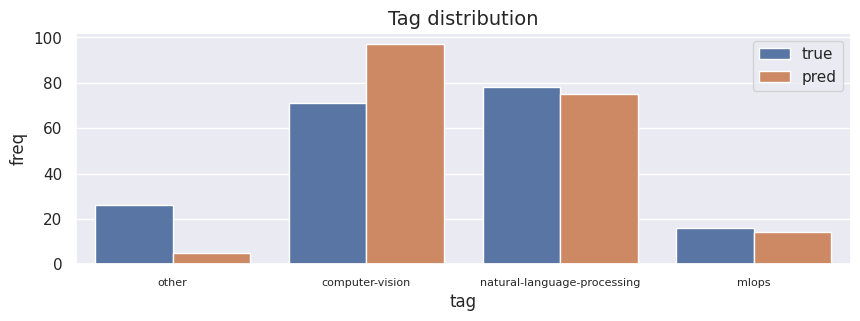

In [ ]:
# Zero-shot with GPT 3.5
method = "zero_shot"
model = "gpt-3.5-turbo-0613"
y_pred[method][model], performance[method][model] = evaluate(
    test_df=test_df, model=model, system_content=system_content,
    assistant_content="", tags=tags)

100%|██████████| 191/191 [02:33<00:00,  1.24it/s]

{
  "precision": 0.9184988617678856,
  "recall": 0.9162303664921466,
  "f1": 0.9164496993493441
}


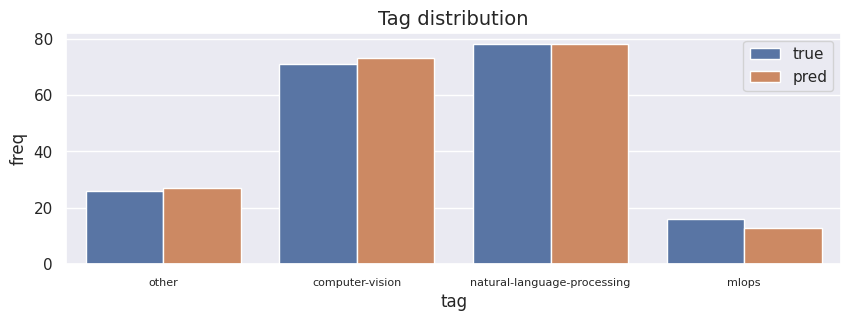

In [ ]:
# Zero-shot with GPT 4
method = "zero_shot"
model = "gpt-4-0613"
y_pred[method][model], performance[method][model] = evaluate(
    test_df=test_df, model=model, system_content=system_content,
    assistant_content="", tags=tags)

### Few-shot learning

Now, we'll be adding a `assistant_context` with a few samples from our training data for each class. The intuition here is that we're giving the model a few examples (few-shot learning) of what each class looks like so that it can learn to generalize better.

In [ ]:
# Create additional context with few samples from each class
num_samples = 2
additional_context = []
cols_to_keep = ["title", "description", "tag"]
for tag in tags:
    samples = train_df[cols_to_keep][train_df.tag == tag][:num_samples].to_dict(orient="records")
    additional_context.extend(samples)
additional_context

[{'title': 'Comparison between YOLO and RCNN on real world videos',
  'description': 'Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.',
  'tag': 'computer-vision'},
 {'title': 'Show, Infer & Tell: Contextual Inference for Creative Captioning',
  'description': 'The beauty of the work lies in the way it architects the fundamental idea that humans look at the overall image and then individual pieces of it.\n',
  'tag': 'computer-vision'},
 {'title': 'Awesome Graph Classification',
  'description': 'A collection of important graph embedding, classification and representation learning papers with implementations.',
  'tag': 'other'},
 {'title': 'Awesome Monte Carlo Tree Search',
  'description': 'A curated list of Monte Carlo tree search papers with implementations. ',
  'tag': 'other'},
 {'title': 'Rethinking Batch Normalization in Transformers',
  'description': 'We found that NLP batch statistics exhibit large variance througho

In [ ]:
# Add additional context
assistant_content = f"""Here are some examples with the correct labels: {additional_context}"""
print (assistant_content)

Here are some examples with the correct labels: [{'title': 'Comparison between YOLO and RCNN on real world videos', 'description': 'Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.', 'tag': 'computer-vision'}, {'title': 'Show, Infer & Tell: Contextual Inference for Creative Captioning', 'description': 'The beauty of the work lies in the way it architects the fundamental idea that humans look at the overall image and then individual pieces of it.\n', 'tag': 'computer-vision'}, {'title': 'Awesome Graph Classification', 'description': 'A collection of important graph embedding, classification and representation learning papers with implementations.', 'tag': 'other'}, {'title': 'Awesome Monte Carlo Tree Search', 'description': 'A curated list of Monte Carlo tree search papers with implementations. ', 'tag': 'other'}, {'title': 'Rethinking Batch Normalization in Transformers', 'description': 'We found that NLP batch statistics exhib

> We could increase the number of samples by increasing the context length. We could also retrieve better few-shot samples by extracting examples from the training data that are similar to the current sample (ex. similar unique vocabulary).

100%|██████████| 191/191 [01:16<00:00,  2.49it/s]


{
  "precision": 0.8727302519880284,
  "recall": 0.8848167539267016,
  "f1": 0.8747488278356492
}


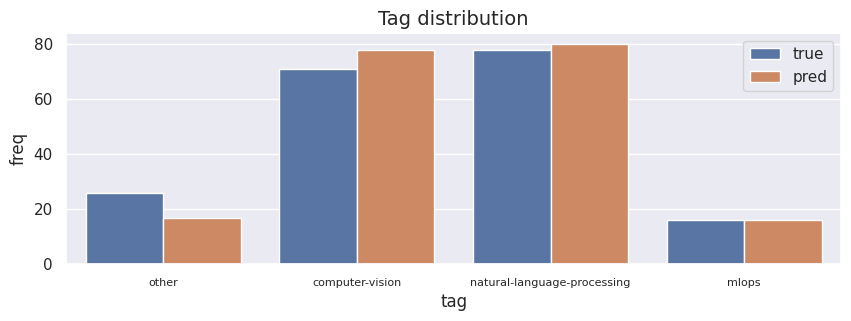

In [ ]:
# Few-shot with GPT 3.5
method = "few_shot"
model = "gpt-3.5-turbo-0613"
y_pred[method][model], performance[method][model] = evaluate(
    test_df=test_df, model=model, system_content=system_content,
    assistant_content=assistant_content, tags=tags)

In [ ]:
# Few-shot with GPT 4
method = "few_shot"
model = "gpt-4-0613"
y_pred[method][model], performance[method][model] = evaluate(
    test_df=test_df, model=model, system_content=system_content,
    assistant_content=assistant_content, tags=tags)

 14%|█▎        | 26/191 [00:16<01:43,  1.59it/s]


RateLimitError: Rate limit reached for gpt-4-0613 in organization org-tIn4DJ5dGDc9ZCihwUrIjnxg on tokens per min (TPM): Limit 10000, Used 9757, Requested 534. Please try again in 1.746s. Visit https://platform.openai.com/account/rate-limits to learn more.

As we can see, few shot learning performs better than it's respective zero shot counter part. GPT 4 has had considerable improvements in reducing hallucinations but for our supervised task this comes at an expense of high precision but lower recall and f1 scores. When GPT 4 is not confident, it would rather predict `other`.

## OSS LLMs

So far, we've only been using closed-source models from OpenAI. While these are *currently* the gold-standard, there are many open-source models that are rapidly catching up ([Falcon 40B](https://huggingface.co/tiiuae/falcon-40b), [Llama 2](https://ai.meta.com/llama/), etc.). Before we see how these models perform on our task, let's first consider a few reasons why we should care about open-source models.

- **data ownership**: you can serve your models and pass data to your models, without having to share it with a third-party API endpoint.
- **fine-tune**: with access to our model's weights, we can actually fine-tune them, as opposed to experimenting with fickle prompting strategies.
- **optimization**: we have full freedom to optimize our deployed models for inference (ex. quantization, pruning, etc.) to reduce costs.

In [ ]:
# Coming soon in August!

## Results

In [ ]:
print(json.dumps(performance, indent=2))

{
  "zero_shot": {
    "gpt-3.5-turbo-0613": {
      "precision": 0.7919133278407181,
      "recall": 0.806282722513089,
      "f1": 0.7807530967691199
    },
    "gpt-4-0613": {
      "precision": 0.9314722577069027,
      "recall": 0.9267015706806283,
      "f1": 0.9271956481845013
    }
  },
  "few_shot": {
    "gpt-3.5-turbo-0613": {
      "precision": 0.8435247936255214,
      "recall": 0.8586387434554974,
      "f1": 0.8447984162323493
    },
    "gpt-4-0613": {
      "precision": 0.9407759040163695,
      "recall": 0.9267015706806283,
      "f1": 0.9302632275594479
    }
  }
}


In [ ]:
# Transform data into a new dictionary with four keys
by_model_and_context = {}
for context_type, models_data in performance.items():
    for model, metrics in models_data.items():
        key = f"{model}_{context_type}"
        by_model_and_context[key] = metrics

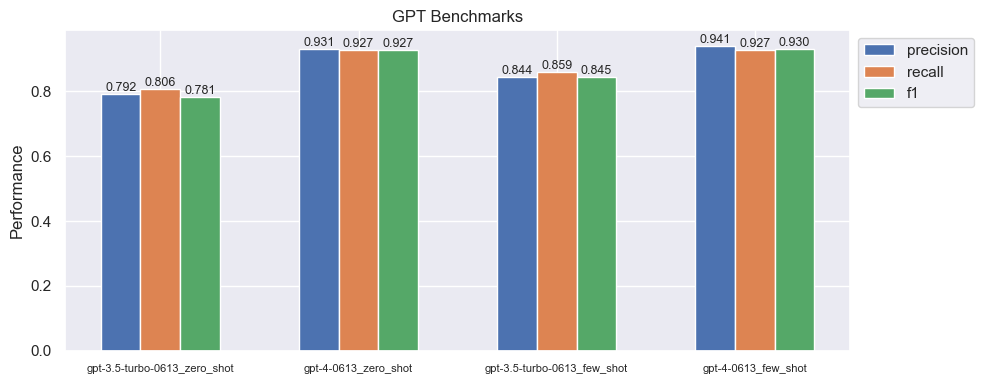

In [ ]:
# Extracting the model names and the metric values
models = list(by_model_and_context.keys())
metrics = list(by_model_and_context[models[0]].keys())

# Plotting the bar chart with metric scores on top of each bar
fig, ax = plt.subplots(figsize=(10, 4))
width = 0.2
x = range(len(models))

for i, metric in enumerate(metrics):
    metric_values = [by_model_and_context[model][metric] for model in models]
    ax.bar([pos + width * i for pos in x], metric_values, width, label=metric)
    # Displaying the metric scores on top of each bar
    for pos, val in zip(x, metric_values):
        ax.text(pos + width * i, val, f'{val:.3f}', ha='center', va='bottom', fontsize=9)

ax.set_xticks([pos + width for pos in x])
ax.set_xticklabels(models, rotation=0, ha='center', fontsize=8)
ax.set_ylabel('Performance')
ax.set_title('GPT Benchmarks')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

Our best model is GPT 4 with few shot learning at an f1 score of ~92%. We will see in the [Made With ML course](https://madewithml.com/) how fine-tuning an LLM with a proper training dataset to change the actual weights of the last N layers (as opposed to the hard prompt tuning here) will yield similar/slightly better results to GPT 4 (at a fraction of the model size and inference costs).

However, the best system might actually be a combination of using these few-shot hard prompt LLMs alongside fine-tuned LLMs. For example, our fine-tuned LLMs in the course will perform well when the test data is similar to the training data (similar distributions of vocabulary, etc.) but may not perform well on out of distribution. Whereas, these hard prompted LLMs, by themselves or augmented with additional context (ex. arXiv plugins in our case), could be used when our primary fine-tuned model is not so confident.